# ***Kaggle:*** Chess Evaluations

| Author's Name         | NIU     |
| --------------------- | ------- |
| Albert Capdevila      | 1587933 |

<small>*This Jupyter Notebook is submitted as an assignment for the Machine Learning subject in the Computer Engineering degree at the Universitat Autònoma de Barcelona (UAB).*<small>

## 1. Problem definition

In computer chess, an evaluation function estimates the strength of a position by assigning a numerical score that indicates which side (White or Black) has the advantage and by how much.

This score is based on the values of chess pieces, which are traditionally:
| Piece  | Pawn | Knight | Bishop | Rook | Queen |
|--------|------|--------|--------|------|-------|
| Symbol | ![Pawn](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Chess_plt45.svg/45px-Chess_plt45.svg.png) | ![Knight](https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Chess_nlt45.svg/45px-Chess_nlt45.svg.png) | ![Bishop](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Chess_blt45.svg/45px-Chess_blt45.svg.png) | ![Rook](https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/Chess_rlt45.svg/45px-Chess_rlt45.svg.png) | ![Queen](https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Chess_qlt45.svg/45px-Chess_qlt45.svg.png) |
| Value  | 1    | 3      | 3      | 5    | 9     |

<small>*The value of the king is undefined as it cannot be captured, let alone traded, during the course of the game. Chess engines usually assign the king an arbitrary large value such as 200 points [¹](#references).*</small>

These values show that, for example, capturing a bishop is equivalent to capturing three pawns. Therefore, all of them can be expressed in *'pawn units'*.

It’s also important to note that evaluations are symmetric, with positive values indicating an advantage for White and negative values for Black. For example, a negative evaluation of $-3$ pawns may indicate that Black has an advantage equivalent to three pawns, a bishop, or a knight.

Usually, these evaluations are calculated by complex algorithms, such as *Stockfish*, which are based on **minimax** principles, calculating, pruning, and predicting the best moves across multiple levels of depth. These algorithms can be slow and computationally intensive, as they analyze many possible future moves in a position. This notebook will explore the use of regression models to achieve similar results more quickly.

***In this notebook, we aim to estimate the evaluation score of a chess position through feature extraction and simple regression techniques.***



## 2. Data collection

For this machine learning problem, we will use the **Chess Evaluations** dataset, available [here](https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations/data) on Kaggle. The dataset contains two columns: 

| Feature             | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| **Position (FEN)**  | This is a string representing the chess position in Forsyth-Edwards Notation (FEN). |
| **Evaluation**      | This is the evaluation of the position in ***centipawns***. `#` means that there is forced checkmate. |

The evaluations are in centi-pawns and are generated from Stockfish 11 at depth 22.

Let’s download and import the dataset:

In [21]:
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import os 

api = KaggleApi()
api.authenticate()

dataser_owner = 'ronakbadhe'
dataset_name= 'chess-evaluations'
dataset = f'{dataser_owner}/{dataset_name}'
target = 'Evaluation'

if not os.path.isdir('data'):
  print("The 'data' directory was not found")
  print("Downloading the dataset from Kaggle...")
  os.mkdir('data')
  api.dataset_download_files(dataset = dataset,path = 'data')
  zf = ZipFile(f'data/{dataset_name}.zip')
  zf.extractall(f'data')
  zf.close()
  os.remove(f'data/{dataset_name}.zip')
  print("Dataset downloaded successfully ✓")
else:
  print("The 'data' directory was found successfully ✓")

The 'data' directory was found successfully ✓


In [22]:
csvFile = "chessData.csv"
print(f"Reading the file '{csvFile}'...")

df = pd.read_csv(f'data/{csvFile}')

print(f"File '{csvFile}' read successfully ✓")

Reading the file 'chessData.csv'...
File 'chessData.csv' read successfully ✓


In [23]:
# Reducing the dataset size to make it faster to work with
from sklearn.model_selection import train_test_split

_, df = train_test_split(df, test_size=0.01, random_state=42)

In [24]:
df.head()

,FEN,Evaluation
11784899,r3k2r/1b2bppp/p1n1pn2/1p2N1B1/8/2NB1P2/PPP3PP/...,-35
8860705,r3k2r/1pp2p2/1bnp1q2/p2Bp1p1/PP2P1bP/1QPP1N2/3...,-201
7376649,6k1/2p3pp/8/8/P3R3/3r1PP1/5K1P/8 b - - 0 30,+121
2224083,1r6/2rnppkp/1q1p2n1/2pP2p1/2b5/1P4PP/P1QNPPB1/...,+280
4108821,5k2/3R4/1p1p4/3n2pp/8/8/PP6/6K1 b - - 1 35,+328


## 3. Data preprocessing

### 3.1 Missing Data

In [25]:
df.isna().sum()

FEN           0
Evaluation    0
dtype: int64

Since there are no missing values, there is no need to handle NaN values.

### 3.2 Data Conversion

In [26]:
df.dtypes

FEN           object
Evaluation    object
dtype: object

The evaluation feature is a string that starts with either a "+" or "-" symbol. To use it in the model, it will need to be converted into a numeric value.

It may also include the character `#`, but since this is not relevant to the current problem, we will ignore it.

In [27]:
tqdm.pandas(desc="Converting 'Evaluation' to numeric values")
df['Evaluation'] = df['Evaluation'].progress_apply(lambda x: int(x) if '#' not in x else int(x.replace('#', '')))

Converting 'Evaluation' to numeric values: 100%|██████████| 129581/129581 [00:00<00:00, 563207.61it/s]


In [28]:
df.dtypes

FEN           object
Evaluation     int64
dtype: object

### 3.3 Data Normalization

Apart from the target feature (Evaluation), the dataset contains only one feature: FEN, which cannot be normalized. Therefore, normalization is not applicable in this case.

### 3.4 Feature extraction

In this section, we will focus on feature extraction, which is the most important step in building our model to predict the evaluation of a chess position. At the moment, we only have the FEN notation of the chess position, and our goal is to extract useful features from it.

#### 3.4.1 Information in the FEN Notation

Forsyth–Edwards Notation (FEN) is a standard notation for describing a particular board position of a chess game.

A typical FEN string looks like this: `rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1`

The FEN string above represents the following board position:

<img src="img/example_board.svg" alt="Example Board" width="300"/>

A FEN string has six fields, each separated by a space:

1. **Piece placement data:**

    It is the arrangement of pieces on the board, row by row, from top to bottom. Each piece is represented by a letter (uppercase for White and lowercase for Black). Empty squares are indicated by numbers.

2. **Active color:**

    Indicates which side is to move (`w` for White, `b` for Black).

3. **Castling availability:**

    If no castling is possible, this field is `-`. Otherwise, it shows `K`, `Q`, `k`, or `q` for available castling options.

4. **En passant target square:**

    Indicates the square where an en passant capture is possible, or `-` if not.

5. **Halfmove clock:**

    Counts the number of halfmoves since the last pawn advance or capture, used for the 50-move rule. 

6. **Fullmove number:**

    Tracks the total number of moves in the game, starting at 1 and incrementing after each Black move.

Only using this information, we can start extracting some simple new features:

In [ ]:
import sys

answ = input("Would you like to the preprocessing? It might take a bit long Y/N")
if answ.upper() == 'N':
    print("Exited successfully")
    sys.exit()

<small>*(Alternatively, if you’ve already performed the preprocessing, you can load the data [here](#import-checkpoint))*</small>

In [30]:
def count_white_pieces(fen):
    return len(re.findall(r'[KQRBNP]', fen))

def count_black_pieces(fen):
    return len(re.findall(r'[kqrbnp]', fen))

tqdm.pandas(desc="Adding column 'White_pieces_count'")
df['White_pieces_count'] = df['FEN'].progress_apply(count_white_pieces)
tqdm.pandas(desc="Adding column 'Black_pieces_count'")
df['Black_pieces_count'] = df['FEN'].progress_apply(count_black_pieces)

Adding column 'White_pieces_count':   0%|          | 0/129581 [00:00<?, ?it/s]

Adding column 'Black_pieces_count': 100%|██████████| 129581/129581 [00:00<00:00, 157453.00it/s]


In [31]:
piece_values = {
    'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K' : 200,
    'p': -1, 'n': -3, 'b': -3, 'r': -5, 'q': -9, 'k' : -200,
    ' ' : 0
}

# The king's value is ignored for now.

def get_white_material(fen):
    return sum(piece_values[piece] for piece in re.findall(r'[QRBNP]', fen))

def get_black_material(fen):
    return -sum(piece_values[piece] for piece in re.findall(r'[qrbnp]', fen))

tqdm.pandas(desc="Adding column 'White_material'")
df['White_material'] = df['FEN'].progress_apply(get_white_material)

tqdm.pandas(desc="Adding column 'Black_material'")
df['Black_material'] = df['FEN'].progress_apply(get_black_material)

df["Material_difference"] = df['White_material'] - df['Black_material']
print("Added column 'Material_difference' ✓")

Adding column 'Black_material': 100%|██████████| 129581/129581 [00:01<00:00, 111089.08it/s]

Added column 'Material_difference' ✓


In [32]:
def get_turn(fen):
    return 1 if fen.split(' ')[1] == 'w' else -1

tqdm.pandas(desc="Adding column 'Turn'")
df['Turn'] = df['FEN'].progress_apply(get_turn)

Adding column 'Turn': 100%|██████████| 129581/129581 [00:00<00:00, 492427.97it/s]


In [33]:
def get_castling(fen, char):
    return int(char in fen.split(' ')[2])

tqdm.pandas(desc="Adding column 'White_king_castling'")
df['White_king_castling'] = df['FEN'].progress_apply(lambda fen: get_castling(fen, 'K'))

tqdm.pandas(desc="Adding column 'White_queen_castling'")
df['White_queen_castling'] = df['FEN'].progress_apply(lambda fen: get_castling(fen, 'Q'))

tqdm.pandas(desc="Adding column 'Black_king_castling'")
df['Black_king_castling'] = df['FEN'].progress_apply(lambda fen: get_castling(fen, 'k'))

tqdm.pandas(desc="Adding column 'Black_queen_castling'")
df['Black_queen_castling'] = df['FEN'].progress_apply(lambda fen: get_castling(fen, 'q'))

df['Castling_difference'] = df['White_king_castling'] + df['White_queen_castling'] - df['Black_king_castling'] - df['Black_queen_castling']
print("Added column 'Castling_difference' ✓")


Adding column 'Black_queen_castling': 100%|██████████| 129581/129581 [00:00<00:00, 481710.67it/s]

Added column 'Castling_difference' ✓


In [34]:
def get_en_passant(fen):
    # This feature is 1 if en passant is available for White, -1 for Black, and 0 if none
    return int(fen.split(' ')[3] != '-') * 1 if fen.split(' ')[1] == 'w' else -1

tqdm.pandas(desc="Adding column 'En_passant'")
df['En_passant'] = df['FEN'].progress_apply(get_en_passant)

Adding column 'En_passant': 100%|██████████| 129581/129581 [00:00<00:00, 433363.27it/s]


In [35]:
def get_rule50(fen):
    return int(fen.split(' ')[4]) * 1 if fen.split(' ')[1] == 'w' else -1

tqdm.pandas(desc="Adding column 'Rule_50'")
df['Rule_50'] = df['FEN'].progress_apply(get_rule50)

Adding column 'Rule_50': 100%|██████████| 129581/129581 [00:00<00:00, 407493.13it/s]


In [36]:
def get_n_moves(fen):
    return int(fen.split(' ')[5]) + int(fen.split(' ')[1] == 'b')

tqdm.pandas(desc="Adding column 'N_moves'")
df['N_moves'] = df['FEN'].progress_apply(get_n_moves)

Adding column 'N_moves': 100%|██████████| 129581/129581 [00:00<00:00, 312787.35it/s]


Let's see the correlations between the new features and the target variable:

In [37]:
correlations = df.corr(numeric_only=True)['Evaluation']
sorted_correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)
print("Correlations with 'Evaluation' (sorted by absolute value):")
print(sorted_correlations)

Correlations with 'Evaluation' (sorted by absolute value):
Evaluation              1.000000
Material_difference     0.196688
White_pieces_count      0.042156
Black_pieces_count     -0.041349
White_material          0.031842
Black_material         -0.022179
En_passant              0.021284
Turn                    0.021133
Rule_50                 0.013880
White_king_castling    -0.003880
Black_king_castling    -0.002919
Black_queen_castling   -0.002685
N_moves                 0.002614
White_queen_castling   -0.002510
Castling_difference    -0.000297
Name: Evaluation, dtype: float64


There are no significant correlations.

#### 3.4.2 Information from the Game Position (General)

Currently, we only extract information from the FEN string, not from the position itself (for instance, two positions with the same pieces, turn, en passant, and number of moves would appear identical to the model).

We need to extract information directly from the game. To achieve this, we'll use the chess library to obtain a board representation and apply some of its functions to build new features.

In [38]:
%pip install chess
import chess

Note: you may need to restart the kernel to use updated packages.


In [39]:
def get_board(fen):
    return chess.Board(fen)

tqdm.pandas(desc="Adding column 'Board'")
df['Board'] = df['FEN'].progress_apply(get_board)

Adding column 'Board': 100%|██████████| 129581/129581 [00:13<00:00, 9739.10it/s] 


Here are a few features I think could have a strong correlation with the evaluation:

* **Attack count:**
    It is the number of squares attacked by each individual piece of a player. If a square is attacked by more than one piece, it is counted multiple times.

In [40]:
def get_attacks_count(board, color):
    return sum(len(board.attackers(color, square)) for square in chess.SQUARES)

tqdm.pandas(desc="Adding column 'White_attacks'")
df['White_attacks'] = df['Board'].progress_apply(lambda board: get_attacks_count(board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_attacks'")
df['Black_attacks'] = df['Board'].progress_apply(lambda board: get_attacks_count(board, chess.BLACK))

df["Attacks_difference"] = df['White_attacks'] - df['Black_attacks']
print("Added column 'Attacks_difference' ✓")

Adding column 'Black_attacks': 100%|██████████| 129581/129581 [00:24<00:00, 5292.90it/s]

Added column 'Attacks_difference' ✓


* **Central attack count**: It is the number of attacks on the central squares (d4, e4, d5, e5) by each individual piece of a player. If a square is attacked by more than one piece, it is counted multiple times. The central squares are often key in chess, as controlling them typically gives strategic advantages.

In [41]:
def get_central_attacks_count(board, color):
    central_squares = [chess.D4, chess.E4, chess.D5, chess.E5]
    return sum(len(board.attackers(color, square)) for square in central_squares)

tqdm.pandas(desc="Adding column 'White_central_attacks'")
df['White_central_attacks'] = df['Board'].progress_apply(lambda board: get_central_attacks_count(board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_central_attacks'")
df['Black_central_attacks'] = df['Board'].progress_apply(lambda board: get_central_attacks_count(board, chess.BLACK))
df["Central_attacks_difference"] = df['White_central_attacks'] - df['Black_central_attacks']
print("Added column 'Central_attacks_difference' ✓")

Adding column 'Black_central_attacks': 100%|██████████| 129581/129581 [00:01<00:00, 67347.83it/s]

Added column 'Central_attacks_difference' ✓


* **Legal moves:**
    It is the total number of legal moves available for a player in the current position.

In [42]:
def get_legal_moves(board, color):
    orig_turn = board.turn 
    board.turn = color
    legal_moves = len(list(board.legal_moves))
    board.turn = orig_turn
    return legal_moves

tqdm.pandas(desc="Adding column 'White_legal_moves'")
df['White_legal_moves'] = df['Board'].progress_apply(lambda board: get_legal_moves(board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_legal_moves'")
df['Black_legal_moves'] = df['Board'].progress_apply(lambda board: get_legal_moves(board, chess.BLACK))

df["Legal_moves_difference"] = df['White_legal_moves'] - df['Black_legal_moves']
print("Added column 'Legal_moves_difference' ✓")

Adding column 'Black_legal_moves': 100%|██████████| 129581/129581 [00:11<00:00, 11404.98it/s]

Added column 'Legal_moves_difference' ✓


* **Attacked pieces**:
    It is the total number of opponent attacks on squares occupied by a player's pieces.

In [43]:
def get_attacked_pieces(board, color):
    attacked_pieces = 0
    opponent_color = chess.WHITE if color == chess.BLACK else chess.BLACK 
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == color:
            attacked_pieces += len(board.attackers(opponent_color, square))

    return attacked_pieces

tqdm.pandas(desc="Adding column 'White_attacked'")
df['White_attacked'] = df['Board'].progress_apply(lambda board: get_attacked_pieces(board, chess.WHITE))
tqdm.pandas(desc="Adding column 'Black_attacked'")
df['Black_attacked'] = df['Board'].progress_apply(lambda board: get_attacked_pieces(board, chess.BLACK))

df["Attacked_difference"] = df['Black_attacked'] - df['White_attacked']
print("Added column 'Attacked_difference' ✓")

Adding column 'Black_attacked': 100%|██████████| 129581/129581 [00:12<00:00, 10544.67it/s]

Added column 'Attacked_difference' ✓


- **Check:** Verifies if a player's king is under attack

In [44]:
def get_check(board):
    return int(board.is_check()) * 1 if board.turn else -1

tqdm.pandas(desc="Adding column 'Check'")
df['Check'] = df['Board'].progress_apply(get_check)

Adding column 'Check': 100%|██████████| 129581/129581 [00:00<00:00, 313170.52it/s]


<small>*"In chess, doubled pawns are two pawns of the same color residing on the same file. Pawns can become doubled only when one pawn captures onto a file on which another friendly pawn resides. [...] In most cases, doubled pawns are considered a weakness due to their inability to defend each other." [²](#references)*</small>


* **Doubled pawns**: It is the count of how many extra pawns are stacked in each file for a player

In [45]:
def count_doubled_pawns(board, color):
    doubled_pawns = 0
    for file in chess.FILE_NAMES:
        column_squares = [chess.square(chess.FILE_NAMES.index(file), rank) for rank in range(8)]
        pawns_in_file = sum(1 for square in column_squares if board.piece_at(square) == chess.Piece(chess.PAWN, color))
        if pawns_in_file > 1:
            doubled_pawns += pawns_in_file - 1
    return doubled_pawns

tqdm.pandas(desc="Adding column 'White_doubled_pawns'")
df['White_doubled_pawns'] = df['Board'].progress_apply(lambda board: count_doubled_pawns(board, chess.WHITE))
tqdm.pandas(desc="Adding column 'Black_doubled_pawns'")
df['Black_doubled_pawns'] = df['Board'].progress_apply(lambda board: count_doubled_pawns(board, chess.BLACK))

df["Doubled_pawns_difference"] = df['White_doubled_pawns'] - df['Black_doubled_pawns']
print("Added column 'Doubled_pawns_difference' ✓")

Adding column 'Black_doubled_pawns': 100%|██████████| 129581/129581 [00:22<00:00, 5717.29it/s]

Added column 'Doubled_pawns_difference' ✓


<small>*"In chess, a fork is a tactic in which a piece attacks multiple enemy pieces simultaneously. The attacker usually aims to capture one of the forked pieces" [³](#references)*</small>

- **Forks:** Counts the number of forks for each player.

In [46]:
def get_forks(board, color):
    forks = 0
    for square, piece in board.piece_map().items():
        if piece.color == color:
            attacked_squares = board.attacks(square)
            if len([target for target in attacked_squares if board.piece_at(target) and board.piece_at(target).color != color]) > 1:
                forks += 1

    return forks

tqdm.pandas(desc="Adding column 'White_forks'")
df['White_forks'] = df['Board'].progress_apply(lambda board: get_forks(board, chess.WHITE))
tqdm.pandas(desc="Adding column 'Black_forks'")
df['Black_forks'] = df['Board'].progress_apply(lambda board: get_forks(board, chess.BLACK))

df["Forks_difference"] = df['White_forks'] - df['Black_forks']
print("Added column 'Forks_difference' ✓")

Adding column 'Black_forks': 100%|██████████| 129581/129581 [00:17<00:00, 7620.17it/s]

Added column 'Forks_difference' ✓


*<small>"An open file in chess is a file with no pawns of either color on it. [...] Having rooks or queens on open files or half-open files is considered advantageous, as it allows a player to attack more easily" [⁴](#references)</small>*

* **Open File Control**: Counts the number of open files controlled by each player.

In [47]:
def open_file_control(board, color):
    open_files = 0
    for file in range(8):
        squares = [chess.square(file, rank) for rank in range(8)]
        if all(board.piece_at(square) is None or board.piece_at(square).color == color and board.piece_at(square).piece_type != chess.PAWN for square in squares):
            open_files += 1
    return open_files

tqdm.pandas(desc="Adding column 'White_open_files'")
df['White_open_files'] = df['Board'].progress_apply(lambda board: open_file_control(board, chess.WHITE))
tqdm.pandas(desc="Adding column 'Black_open_files'")
df['Black_open_files'] = df['Board'].progress_apply(lambda board: open_file_control(board, chess.BLACK))

df['Open_files_difference'] = df['White_open_files'] - df['Black_open_files']
print("Added column 'Open_files_difference' ✓")

Adding column 'Black_open_files': 100%|██████████| 129581/129581 [00:07<00:00, 18429.49it/s]

Added column 'Open_files_difference' ✓


* **Major Control**: Calculates the total number of squares controlled by rooks and queens for each player.

In [48]:
def count_major_control(board, color):
    major_pieces = board.pieces(chess.ROOK, color) | board.pieces(chess.QUEEN, color)
    return sum(len(board.attacks(square)) for square in major_pieces)

tqdm.pandas(desc="Adding column 'White_major_control'")
df['White_major_control'] = df['Board'].progress_apply(lambda board: count_major_control(board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_major_control'")
df['Black_major_control'] = df['Board'].progress_apply(lambda board: count_major_control(board, chess.BLACK))

df['Major_control_difference'] = df['White_major_control'] - df['Black_major_control']
print("Added column 'Major_control_difference' ✓")

Adding column 'Black_major_control': 100%|██████████| 129581/129581 [00:01<00:00, 89063.40it/s]

Added column 'Major_control_difference' ✓


* **Sixth-Rank Pawns**: Counts the number of pawns for each player positioned on the sixth rank. These become significantly more powerful as they are closer to promotion.

In [49]:
def count_sixth_rank_pawns(fen, color):
    rows = fen.split()[0].split("/")
    rank_index = 2 if color == chess.WHITE else 5
    rank = rows[rank_index]
    
    pawn_char = 'P' if color == chess.WHITE else 'p'
    return rank.count(pawn_char)

tqdm.pandas(desc="Adding column 'White_sixth_rank_pawns'")
df['White_sixth_rank_pawns'] = df['FEN'].progress_apply(lambda fen: count_sixth_rank_pawns(fen, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_sixth_rank_pawns'")
df['Black_sixth_rank_pawns'] = df['FEN'].progress_apply(lambda fen: count_sixth_rank_pawns(fen, chess.BLACK))

df['Sixth_rank_pawns_difference'] = df['White_sixth_rank_pawns'] - df['Black_sixth_rank_pawns']
print("Added column 'Sixth_rank_pawns_difference' ✓")

Adding column 'Black_sixth_rank_pawns': 100%|██████████| 129581/129581 [00:00<00:00, 346474.08it/s]

Added column 'Sixth_rank_pawns_difference' ✓


Let's see the current strongest correlations: 

In [50]:
correlations = df.corr(numeric_only=True)['Evaluation']
sorted_correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)
print("Correlations with 'Evaluation' (sorted by absolute value):")
print(sorted_correlations)

Correlations with 'Evaluation' (sorted by absolute value):
Evaluation                     1.000000
Attacks_difference             0.231071
Material_difference            0.196688
Legal_moves_difference         0.183779
Major_control_difference       0.131955
Sixth_rank_pawns_difference    0.129983
Central_attacks_difference     0.104812
White_legal_moves              0.094974
White_sixth_rank_pawns         0.090383
Black_sixth_rank_pawns        -0.090149
Black_legal_moves             -0.089869
White_attacks                  0.064895
Black_central_attacks         -0.064887
Open_files_difference          0.062926
Black_attacks                 -0.057381
White_major_control            0.055943
White_central_attacks          0.054349
White_pieces_count             0.042156
Black_pieces_count            -0.041349
Black_major_control           -0.034771
White_material                 0.031842
Black_attacked                 0.027091
White_forks                    0.026275
Forks_difference     

Using the chess library, we can extract much more information, but we must keep it simple.  

So far, we have focused on attributes that indicate whether a position might be better, but we have ignored the fact that the goal is to infer a specific value: the evaluation provided by Stockfish 11 at 22 levels of depth (considering 22 turns ahead).  

Therefore, we need to identify the features that Stockfish use to generate their evaluations.

#### 3.4.3 Information that Stockfish uses (Simplified)

Stockfish's evaluation function is actually quite complex and uses lots of values to determine its result. We'll focus on the main ones and simplify where needed:

- Middle game evaluation

    - **Piece Value (eg)**: Material is weighted differently during the middlegame.

    - **Psqt (eg)**: Piece-square table bonuses, where certain positions provide an advantage for specific pieces in the middlegame.

    - Pawns:
        - Doubled: *(Simplified: Already considered in 'Double_pawns')*

    - Pieces:
        - **Minor behind pawn**: Knight or bishop when behind a pawn
        - **Bishop pawns**: Number of pawns on the same color square as the bishop *(Simplified)*
        - **Bishop xray pawns**: Advantatge for every opponent pawn in the diagonal of a bishop
        - **Rook on queen file**: Simple bonus for a rook that is on the same file as any queen
        - **Rook on file**: Rook when on an open file *(Simplified)*
        - **Long diagonal bishop**: Bonus for bishop on a long diagonal which can "see" both center squares.

    - Mobility: *(Simplified: Already considered in 'Legal_moves')*

    - Threats
        - **Hanging**: Weak enemies not defended by opponent *(Simplified)*

    - **Passed**: Bonuses for passed pawns *(Simplified)*

    - **King**: Bonuses for player's pieces around the king *(Simplified)* 

- End game evaluation

    - **Piece Value (EG)**: Material is weighted differently during the endgame.

    - **Psqt (EG)**: Piece-square table bonuses, where certain positions provide an advantage for specific pieces in the endgame.

    It also takes all the above into account, with different weights *(Will be ignored for simplicity)*

- **Phase**: Eval based on the amount of non-pawn material on the board *(Simplified)*

- Rule50: *(Already considered in 'Rule_50')*

- Scale factor: The scale factors are used to scale the endgame evaluation score down *(It will also be ignored)*

- Tempo: *(Already considered in 'Turn')*

<small>*All the bold titles represent new attributes that will be added.*</small>\
<small>*For the full list and details of Stockfish's evaluation, you can check the [source](https://hxim.github.io/Stockfish-Evaluation-Guide/)*</small>

In [51]:
# This board representation will be used to do calculations quicker

def fen_to_numpy(fen):
    rows = fen.split(' ')[0].split('/')
    np_board = np.full((8, 8), ' ', dtype=str)
    for i, row in enumerate(rows):
        col = 0
        for char in row:
            if char.isdigit():
                col += int(char)
            else:
                np_board[i, col] = char
                col += 1
                
    return np_board

tqdm.pandas(desc="Adding column 'Numpy_board'")
df['Numpy_board'] = df['FEN'].progress_apply(fen_to_numpy)

Adding column 'Numpy_board': 100%|██████████| 129581/129581 [00:02<00:00, 44586.94it/s]


In [52]:
piece_values_mg = {
    'P': 124, 'N': 781, 'B': 825, 'R': 1276, 'Q': 2538,
    'p': -124, 'n': -781, 'b': -825, 'r': -1276, 'q': -2538
}

def get_white_material_mg(fen):
    return sum(piece_values_mg[piece] for piece in re.findall(r'[QRBNP]', fen))

def get_black_material_mg(fen):
    return -sum(piece_values_mg[piece] for piece in re.findall(r'[qrbnp]', fen))

tqdm.pandas(desc="Adding column 'White_material_mg'")
df['White_material_mg'] = df['FEN'].progress_apply(get_white_material_mg)

tqdm.pandas(desc="Adding column 'Black_material_mg'")
df['Black_material_mg'] = df['FEN'].progress_apply(get_black_material_mg)

df["Material_mg_difference"] = df['White_material_mg'] - df['Black_material_mg']
print("Added column 'Material_mg_difference' ✓")

Adding column 'Black_material_mg': 100%|██████████| 129581/129581 [00:00<00:00, 140928.74it/s]

Added column 'Material_mg_difference' ✓


In [53]:
piece_values_eg = {
    'P': 206, 'N': 854, 'B': 915, 'R': 1380, 'Q': 2682,
    'p': -206, 'n': -854, 'b': -915, 'r': -1380, 'q': -2682
}

def get_white_material_eg(fen):
    return sum(piece_values_eg[piece] for piece in re.findall(r'[QRBNP]', fen))

def get_black_material_eg(fen):
    return -sum(piece_values_eg[piece] for piece in re.findall(r'[qrbnp]', fen))

tqdm.pandas(desc="Adding column 'White_material_eg'")
df['White_material_eg'] = df['FEN'].progress_apply(get_white_material_eg)

tqdm.pandas(desc="Adding column 'Black_material_eg'")
df['Black_material_eg'] = df['FEN'].progress_apply(get_black_material_eg)

df["Material_eg_difference"] = df['White_material_eg'] - df['Black_material_eg']
print("Added column 'Material_eg_difference' ✓")

Adding column 'Black_material_eg': 100%|██████████| 129581/129581 [00:00<00:00, 139178.30it/s]

Added column 'Material_eg_difference' ✓


These are the positional weights that Stockfish uses for each piece:

In [54]:
psqt_mg = np.array([[[0, 0, 0, 0, 0, 0, 0, 0],  [3, 3, 10, 19, 16, 19, 7, -5],  [-9, -15, 11, 15, 32, 22, 5, -22],  [-4, -23, 6, 20, 40, 17, 4, -8],  [13, 0, -13, 1, 11, -2, -13, 5],  [5, -12, -7, 22, -8, -5, -15, -8],  [-7, 7, -3, -13, 5, -16, 10, -8],  [0, 0, 0, 0, 0, 0, 0, 0]],
 [[-175, -92, -74, -73, -73, -74, -92, -175],  [-77, -41, -27, -15, -15, -27, -41, -77],  [-61, -17, 6, 12, 12, 6, -17, -61],  [-35, 8, 40, 49, 49, 40, 8, -35],  [-34, 13, 44, 51, 51, 44, 13, -34],  [-9, 22, 58, 53, 53, 58, 22, -9],  [-67, -27, 4, 37, 37, 4, -27, -67],  [-201, -83, -56, -26, -26, -56, -83, -201]],
 [[-53, -5, -8, -23, -23, -8, -5, -53],  [-15, 8, 19, 4, 4, 19, 8, -15],  [-7, 21, -5, 17, 17, -5, 21, -7],  [-5, 11, 25, 39, 39, 25, 11, -5],  [-12, 29, 22, 31, 31, 22, 29, -12],  [-16, 6, 1, 11, 11, 1, 6, -16],  [-17, -14, 5, 0, 0, 5, -14, -17],  [-48, 1, -14, -23, -23, -14, 1, -48]],
 [[-31, -20, -14, -5, -5, -14, -20, -31],  [-21, -13, -8, 6, 6, -8, -13, -21],  [-25, -11, -1, 3, 3, -1, -11, -25],  [-13, -5, -4, -6, -6, -4, -5, -13],  [-27, -15, -4, 3, 3, -4, -15, -27],  [-22, -2, 6, 12, 12, 6, -2, -22],  [-2, 12, 16, 18, 18, 16, 12, -2],  [-17, -19, -1, 9, 9, -1, -19, -17]],
 [[3, -5, -5, 4, 4, -5, -5, 3],  [-3, 5, 8, 12, 12, 8, 5, -3],  [-3, 6, 13, 7, 7, 13, 6, -3],  [4, 5, 9, 8, 8, 9, 5, 4],  [0, 14, 12, 5, 5, 12, 14, 0],  [-4, 10, 6, 8, 8, 6, 10, -4],  [-5, 6, 10, 8, 8, 10, 6, -5],  [-2, -2, 1, -2, -2, 1, -2, -2]],
 [[271, 327, 271, 198, 198, 271, 327, 271],  [278, 303, 234, 179, 179, 234, 303, 278],  [195, 258, 169, 120, 120, 169, 258, 195],  [164, 190, 138, 98, 98, 138, 190, 164],  [154, 179, 105, 70, 70, 105, 179, 154],  [123, 145, 81, 31, 31, 81, 145, 123],  [88, 120, 65, 33, 33, 65, 120, 88],  [59, 89, 45, -1, -1, 45, 89, 59]]]
)

psqt_eg = np.array([[[0, 0, 0, 0, 0, 0, 0, 0],  [-10, -6, 10, 0, 14, 7, -5, -19],  [-10, -10, -10, 4, 4, 3, -6, -4],  [6, -2, -8, -4, -13, -12, -10, -9],  [10, 5, 4, -5, -5, -5, 14, 9],  [28, 20, 21, 28, 30, 7, 6, 13],  [0, -11, 12, 21, 25, 19, 4, 7],  [0, 0, 0, 0, 0, 0, 0, 0]],
 [[-96, -65, -49, -21, -21, -49, -65, -96],  [-67, -54, -18, 8, 8, -18, -54, -67],  [-40, -27, -8, 29, 29, -8, -27, -40],  [-35, -2, 13, 28, 28, 13, -2, -35],  [-45, -16, 9, 39, 39, 9, -16, -45],  [-51, -44, -16, 17, 17, -16, -44, -51],  [-69, -50, -51, 12, 12, -51, -50, -69],  [-100, -88, -56, -17, -17, -56, -88, -100]],
 [[-57, -30, -37, -12, -12, -37, -30, -57],  [-37, -13, -17, 1, 1, -17, -13, -37],  [-16, -1, -2, 10, 10, -2, -1, -16],  [-20, -6, 0, 17, 17, 0, -6, -20],  [-17, -1, -14, 15, 15, -14, -1, -17],  [-30, 6, 4, 6, 6, 4, 6, -30],  [-31, -20, -1, 1, 1, -1, -20, -31],  [-46, -42, -37, -24, -24, -37, -42, -46]],
 [[-9, -13, -10, -9, -9, -10, -13, -9],  [-12, -9, -1, -2, -2, -1, -9, -12],  [6, -8, -2, -6, -6, -2, -8, 6],  [-6, 1, -9, 7, 7, -9, 1, -6],  [-5, 8, 7, -6, -6, 7, 8, -5],  [6, 1, -7, 10, 10, -7, 1, 6],  [4, 5, 20, -5, -5, 20, 5, 4],  [18, 0, 19, 13, 13, 19, 0, 18]],
 [[-69, -57, -47, -26, -26, -47, -57, -69],  [-55, -31, -22, -4, -4, -22, -31, -55],  [-39, -18, -9, 3, 3, -9, -18, -39],  [-23, -3, 13, 24, 24, 13, -3, -23],  [-29, -6, 9, 21, 21, 9, -6, -29],  [-38, -18, -12, 1, 1, -12, -18, -38],  [-50, -27, -24, -8, -8, -24, -27, -50],  [-75, -52, -43, -36, -36, -43, -52, -75]],
 [[1, 45, 85, 76, 76, 85, 45, 1],  [53, 100, 133, 135, 135, 133, 100, 53],  [88, 130, 169, 175, 175, 169, 130, 88],  [103, 156, 172, 172, 172, 172, 156, 103],  [96, 166, 199, 199, 199, 199, 166, 96],  [92, 172, 184, 191, 191, 184, 172, 92],  [47, 121, 116, 131, 131, 116, 121, 47],  [11, 59, 73, 78, 78, 73, 59, 11]]]
)

In [55]:
def get_psqt(weights, np_board, color):
    pieces = 'PNBRQK' if color == chess.WHITE else 'pnbrqk'
    result = 0
    color_weights = weights if color == chess.WHITE else weights[:,::-1,:]
    for index, piece in enumerate(pieces):
        mask = (np_board == piece).astype(int)
        masked = color_weights[index] * mask
        result += masked.sum().sum()
    return result

tqdm.pandas(desc="Adding column 'White_psqt_mg'")
df['White_psqt_mg'] = df['Numpy_board'].progress_apply(lambda np_board: get_psqt(psqt_mg, np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_psqt_mg'")
df['Black_psqt_mg'] = df['Numpy_board'].progress_apply(lambda np_board: get_psqt(psqt_mg, np_board, chess.BLACK))

df["Psqt_mg_difference"] = df['White_psqt_mg'] - df['Black_psqt_mg']
print("Added column 'Psqt_mg_difference' ✓")

Adding column 'Black_psqt_mg': 100%|██████████| 129581/129581 [00:13<00:00, 9965.85it/s] 

Added column 'Psqt_mg_difference' ✓


In [56]:
tqdm.pandas(desc="Adding column 'White_psqt_eg'")
df['White_psqt_eg'] = df['Numpy_board'].progress_apply(lambda np_board: get_psqt(psqt_eg,np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_psqt_eg'")
df['Black_psqt_eg'] = df['Numpy_board'].progress_apply(lambda np_board: get_psqt(psqt_eg,np_board, chess.BLACK))

df["Psqt_eg_difference"] = df['White_psqt_eg'] - df['Black_psqt_eg']
print("Added column 'Psqt_eg_difference' ✓")

Adding column 'Black_psqt_eg': 100%|██████████| 129581/129581 [00:12<00:00, 10352.95it/s]

Added column 'Psqt_eg_difference' ✓


In [57]:
def get_minor_behind_pawn(np_board, color):
    result = 0
    pieces = 'NB' if color == chess.WHITE else 'nb'
    board = np_board if color == chess.WHITE else np_board[::-1,:]
    for piece in pieces:
        idxs = np.argwhere(board == piece)
        idxs = idxs + np.array([-1, 0])
        idxs = idxs[idxs[:, 0] >= 0]
        in_front = board[idxs[:, 0], idxs[:, 1]] == 'P' if color == chess.WHITE else board[idxs[:, 0], idxs[:, 1]] == 'p'
        result += in_front.sum()
    return result

tqdm.pandas(desc="Adding column 'White_minor_behind_pawn'")
df['White_minor_behind_pawn'] = df['Numpy_board'].progress_apply(lambda np_board: get_minor_behind_pawn(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_minor_behind_pawn'")
df['Black_minor_behind_pawn'] = df['Numpy_board'].progress_apply(lambda np_board: get_minor_behind_pawn(np_board, chess.BLACK))

df["Minor_behind_pawn_difference"] = df['White_minor_behind_pawn'] - df['Black_minor_behind_pawn']
print("Added column 'Psqt_mg_difference' ✓")

Adding column 'Black_minor_behind_pawn': 100%|██████████| 129581/129581 [00:11<00:00, 11139.41it/s]

Added column 'Psqt_mg_difference' ✓


In [58]:
def get_bishop_pawns(np_board, color):
    result = 0
    pieces = 'B' if color == chess.WHITE else 'b'
    pawns = 'P' if color == chess.WHITE else 'p'
    board = np_board if color == chess.WHITE else np_board[::-1,:]
    bishop_positions = np.argwhere(board == pieces)
    bishop_colors = (bishop_positions[:, 0] + bishop_positions[:, 1]) % 2
    
    for bishop_color in bishop_colors:
        if bishop_color == 0:
            pawns_on_color = (board[::2, ::2] == pawns).sum()
        else:
            pawns_on_color = (board[1::2, 1::2] == pawns).sum()
        
        result += pawns_on_color
    return result

tqdm.pandas(desc="Adding column 'White_bishop_pawns'")
df['White_bishop_pawns'] = df['Numpy_board'].progress_apply(lambda np_board: get_bishop_pawns(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_bishop_pawns'")
df['Black_bishop_pawns'] = df['Numpy_board'].progress_apply(lambda np_board: get_bishop_pawns(np_board, chess.BLACK))

df["Bishop_pawns_difference"] = df['White_bishop_pawns'] - df['Black_bishop_pawns']
print("Added column 'Bishop_pawns_difference' ✓")


Adding column 'Black_bishop_pawns': 100%|██████████| 129581/129581 [00:05<00:00, 22194.57it/s]

Added column 'Bishop_pawns_difference' ✓


In [59]:
def get_bishop_xray_pawns(np_board, color):
    result = 0
    pieces = 'B' if color == chess.WHITE else 'b'
    pawns = 'P' if color == chess.WHITE else 'p'
    board = np_board if color == chess.WHITE else np_board[::-1,:]
    bishop_positions = np.argwhere(board == pieces)
    for bishop_row, bishop_col in bishop_positions:
        for direction in [(-1, -1), (-1, 1), (1, -1), (1, 1)]:
            row, col = bishop_row, bishop_col
            while 0 <= row < board.shape[0] and 0 <= col < board.shape[1]:
                row += direction[0]
                col += direction[1]
                if 0 <= row < board.shape[0] and 0 <= col < board.shape[1]:
                    if board[row, col] == pawns:
                        result += 1
                    if board[row, col] != '.':
                        break

    return result

tqdm.pandas(desc="Adding column 'White_bishop_xray_pawns'")
df['White_bishop_xray_pawns'] = df['Numpy_board'].progress_apply(lambda np_board: get_bishop_xray_pawns(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_bishop_xray_pawns'")
df['Black_bishop_xray_pawns'] = df['Numpy_board'].progress_apply(lambda np_board: get_bishop_xray_pawns(np_board, chess.BLACK))

df["Bishop_xray_pawns_difference"] = df['White_bishop_xray_pawns'] - df['Black_bishop_xray_pawns']
print("Added column 'Bishop_xray_pawns_difference' ✓")

Adding column 'Black_bishop_xray_pawns': 100%|██████████| 129581/129581 [00:04<00:00, 30081.51it/s]

Added column 'Bishop_xray_pawns_difference' ✓


In [60]:
def get_rook_on_queen_file(np_board, color):
    result = 0
    rook_piece = 'R' if color == chess.WHITE else 'r'
    queen_piece = 'Q' if color == chess.WHITE else 'q'
    board = np_board if color == chess.WHITE else np_board[::-1,:]
    rook_positions = np.argwhere(board == rook_piece)
    queen_positions = np.argwhere(board == queen_piece)

    if rook_positions.size > 0 and queen_positions.size > 0:
        rook_cols = rook_positions[:, 1]
        queen_cols = queen_positions[:, 1]
        same_file = np.isin(rook_cols, queen_cols)
        result = same_file.sum()

    return result

tqdm.pandas(desc="Adding column 'White_rook_on_queen_file'")
df['White_rook_on_queen_file'] = df['Numpy_board'].progress_apply(lambda np_board: get_rook_on_queen_file(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_rook_on_queen_file'")
df['Black_rook_on_queen_file'] = df['Numpy_board'].progress_apply(lambda np_board: get_rook_on_queen_file(np_board, chess.BLACK))

df["Rook_on_queen_file_difference"] = df['White_rook_on_queen_file'] - df['Black_rook_on_queen_file']
print("Added column 'Rook_on_queen_file_difference' ✓")

Adding column 'Black_rook_on_queen_file': 100%|██████████| 129581/129581 [00:10<00:00, 12564.88it/s]

Added column 'Rook_on_queen_file_difference' ✓


In [61]:
def get_rook_on_open_file(np_board, color):
    result = 0
    rook_piece = 'R' if color == chess.WHITE else 'r'
    pawns = ['P', 'p']
    board = np_board if color == chess.WHITE else np_board[::-1,:]
    pawn_positions = np.isin(board, pawns)
    files_with_pawns = np.any(pawn_positions, axis=0)
    rook_positions = np.argwhere(board == rook_piece)
    
    if rook_positions.size > 0:
        rook_cols = rook_positions[:, 1]
        open_files = ~files_with_pawns
        rooks_on_open_files = open_files[rook_cols]
        result = rooks_on_open_files.sum()

    return result

tqdm.pandas(desc="Adding column 'White_rook_on_open_file'")
df['White_rook_on_open_file'] = df['Numpy_board'].progress_apply(lambda np_board: get_rook_on_open_file(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_rook_on_open_file'")
df['Black_rook_on_open_file'] = df['Numpy_board'].progress_apply(lambda np_board: get_rook_on_open_file(np_board, chess.BLACK))

df["Rook_on_open_file_difference"] = df['White_rook_on_open_file'] - df['Black_rook_on_open_file']
print("Added column 'Rook_on_open_file_difference' ✓")

Adding column 'Black_rook_on_open_file': 100%|██████████| 129581/129581 [00:09<00:00, 13645.24it/s]

Added column 'Rook_on_open_file_difference' ✓


In [62]:
long_diag = np.array([[1,0,0,0,0,0,0,1],[0,1,0,0,0,0,1,0],[0,0,1,0,0,1,0,0],[0,0,0,1,1,0,0,0],[0,0,0,1,1,0,0,0],[0,0,1,0,0,1,0,0],[0,1,0,0,0,0,1,0],[1,0,0,0,0,0,0,1]]).astype(bool)

In [63]:
def get_long_diagonal_bishop(np_board, color):
    bishop = 'B' if color == chess.WHITE else 'b'
    mask = np_board == bishop
    masked = long_diag * mask
    return masked.sum()

tqdm.pandas(desc="Adding column 'White_long_diagonal_bishop'")
df['White_long_diagonal_bishop'] = df['Numpy_board'].progress_apply(lambda np_board: get_long_diagonal_bishop(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_long_diagonal_bishop'")
df['Black_long_diagonal_bishop'] = df['Numpy_board'].progress_apply(lambda np_board: get_long_diagonal_bishop(np_board, chess.BLACK))

df["Long_diagonal_bishop_difference"] = df['White_long_diagonal_bishop'] - df['Black_long_diagonal_bishop']
print("Added column 'Long_diagonal_bishop_difference' ✓")

Adding column 'Black_long_diagonal_bishop': 100%|██████████| 129581/129581 [00:02<00:00, 62668.12it/s] 

Added column 'Long_diagonal_bishop_difference' ✓


In [64]:
def get_hanging_pieces(board, color):
    hanging_count = 0
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == color:
            if not board.is_attacked_by(color, square):
                hanging_count += 1

    return hanging_count

tqdm.pandas(desc="Adding column 'White_hanging_pieces'")
df['White_hanging_pieces'] = df['Board'].progress_apply(lambda board: get_hanging_pieces(board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_hanging_pieces'")
df['Black_hanging_pieces'] = df['Board'].progress_apply(lambda board: get_hanging_pieces(board, chess.BLACK))

df["Hanging_pieces_difference"] = df['Black_hanging_pieces'] - df['White_hanging_pieces']
print("Added column 'Hanging_pieces_difference' ✓")

Adding column 'Black_hanging_pieces': 100%|██████████| 129581/129581 [00:08<00:00, 15018.23it/s]

Added column 'Hanging_pieces_difference' ✓


In [65]:
def get_passed_pawns(np_board, color):
    result = 0
    pawn_piece = 'P' if color == chess.WHITE else 'p'
    opponent_pawns = 'p' if color == chess.WHITE else 'P'
    board = np_board if color == chess.WHITE else np_board[::-1, :]
    pawn_positions = np.argwhere(board == pawn_piece)

    for pawn_row, pawn_col in pawn_positions:
        file_range = range(max(0, pawn_col - 1), min(board.shape[1], pawn_col + 2))
        opposing_pawns_in_path = any(
            opponent_pawns in board[row, file_range].tolist()
            for row in range(pawn_row + 1, board.shape[0])
        )
        if not opposing_pawns_in_path:
            result += 1

    return result

tqdm.pandas(desc="Adding column 'White_passed_pawns'")
df['White_passed_pawns'] = df['Numpy_board'].progress_apply(lambda np_board: get_passed_pawns(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_passed_pawns'")
df['Black_passed_pawns'] = df['Numpy_board'].progress_apply(lambda np_board: get_passed_pawns(np_board, chess.BLACK))

df["Passed_pawn_difference"] = df['White_passed_pawns'] - df['Black_passed_pawns']
print("Added column 'Passed_pawn_difference' ✓")

Adding column 'Black_passed_pawns': 100%|██████████| 129581/129581 [00:16<00:00, 7930.30it/s]

Added column 'Passed_pawn_difference' ✓


In [66]:
def get_king_support(np_board, color):
    king_piece = 'K' if color == chess.WHITE else 'k'
    player_pieces = "PNBRQ" if color == chess.WHITE else "pnbrq"

    king_position = np.argwhere(np_board == king_piece)
    if king_position.size == 0:
        return 0

    king_row, king_col = king_position[0]

    row_start = max(0, king_row - 1)
    row_end = min(np_board.shape[0], king_row + 2)
    col_start = max(0, king_col - 1)
    col_end = min(np_board.shape[1], king_col + 2)
    surrounding_area = np_board[row_start:row_end, col_start:col_end]

    mask = np.isin(surrounding_area, list(player_pieces))
    return np.sum(mask)

tqdm.pandas(desc="Adding column 'White_king_support'")
df['White_king_support'] = df['Numpy_board'].progress_apply(lambda np_board: get_king_support(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_king_support'")
df['Black_king_support'] = df['Numpy_board'].progress_apply(lambda np_board: get_king_support(np_board, chess.BLACK))

df["King_support_difference"] = df['White_king_support'] - df['Black_king_support']
print("Added column 'King_support_difference' ✓")

Adding column 'Black_king_support': 100%|██████████| 129581/129581 [00:10<00:00, 12572.78it/s]

Added column 'King_support_difference' ✓


In [67]:
piece_values_mg = {
    'P': 124, 'N': 781, 'B': 825, 'R': 1276, 'Q': 2538,
    'p': -124, 'n': -781, 'b': -825, 'r': -1276, 'q': -2538
}

def get_white_non_pawn_material(fen):
    return sum(piece_values_mg[piece] for piece in re.findall(r'[QRBN]', fen))

def get_black_non_pawn_material(fen):
    return -sum(piece_values_mg[piece] for piece in re.findall(r'[qrbn]', fen))

tqdm.pandas(desc="Adding column 'White_non_pawn_material'")
df['White_non_pawn_material'] = df['FEN'].progress_apply(get_white_non_pawn_material)

tqdm.pandas(desc="Adding column 'Black_non_pawn_material'")
df['Black_non_pawn_material'] = df['FEN'].progress_apply(get_black_non_pawn_material)
df["Non_pawn_material_difference"] = df['White_non_pawn_material'] - df['Black_non_pawn_material']
print("Added column 'Non_pawn_material_difference' ✓")

Adding column 'Black_non_pawn_material': 100%|██████████| 129581/129581 [00:00<00:00, 189713.26it/s]

Added column 'Non_pawn_material_difference' ✓


The final correlations are:

In [68]:
correlations = df.corr(numeric_only=True)['Evaluation']
sorted_correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)
print("Correlations with 'Evaluation' (sorted by absolute value):")
print(sorted_correlations[:20])

Correlations with 'Evaluation' (sorted by absolute value):
Evaluation                      1.000000
Attacks_difference              0.231071
Passed_pawn_difference          0.221760
Material_difference             0.196688
Legal_moves_difference          0.183779
Material_eg_difference          0.176207
Material_mg_difference          0.158326
Major_control_difference        0.131955
Sixth_rank_pawns_difference     0.129983
Non_pawn_material_difference    0.125192
Central_attacks_difference      0.104812
Psqt_mg_difference              0.101736
White_legal_moves               0.094974
White_sixth_rank_pawns          0.090383
Black_sixth_rank_pawns         -0.090149
Black_legal_moves              -0.089869
King_support_difference         0.074685
White_psqt_mg                   0.068119
Black_psqt_mg                  -0.067054
Rook_on_open_file_difference    0.066126
Name: Evaluation, dtype: float64


We didn’t identify significant correlations, so we’ll avoid using linear models for predicting the target.

Let’s store all the information to skip this preprocessing step in the future:

In [69]:
df.to_csv("data/checkpoint.csv", index=False)

#### <span style="display: none">Import Checkpoint</span>
You can now import this data at any time:

In [1]:
# Skip this cell if the preprocessing step was already executed
import pandas as pd
target = 'Evaluation'

csvFile = "checkpoint.csv"
print(f"Reading the file '{csvFile}'...")

df = pd.read_csv(f'data/{csvFile}')

print(f"File '{csvFile}' read successfully ✓")

Reading the file 'checkpoint.csv'...
File 'checkpoint.csv' read successfully ✓


In [2]:
fens = df['FEN']
df = df.drop(columns=['FEN', 'Board', 'Numpy_board'])

X, y = df.drop(columns=[target]), df[target]

print(f"{df.shape[1]} new features have been added in total")

85 new features have been added in total


### 3.5 Feature selection

We have extracted a lot of new features, which could cause our model to overfit. So, it's a good idea to perform feature selection.

To do this, we can create a Lasso regressor, forcing zero coefficients for some of the features:

In [3]:
from sklearn.linear_model import Lasso

regr_lasso = Lasso(random_state=42)
regr_lasso.fit(X, y) 

coef_table = pd.DataFrame({'Feature': X.columns,'Coefficient': regr_lasso.coef_})
coef_table

C:\Users\Albert\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.470e+10, tolerance: 8.253e+06
  model = cd_fast.enet_coordinate_descent(


,Feature,Coefficient
0,White_pieces_count,105.231767
1,Black_pieces_count,-105.357820
2,White_material,-0.000000
3,Black_material,0.000000
4,Material_difference,-0.000000
...,...,...
79,Black_king_support,-2.546484
80,King_support_difference,16.847717
81,White_non_pawn_material,-0.038951
82,Black_non_pawn_material,0.041156


Features with a coefficient of 0 are less relevant, so they will be discarded.

In [4]:
discarded = coef_table[coef_table['Coefficient'] <= 1e-10].reset_index(drop=True)
df = df.drop(columns=discarded['Feature'].tolist())
pd.DataFrame(df.columns)

,0
0,Evaluation
1,White_pieces_count
2,Black_queen_castling
3,N_moves
4,White_legal_moves
5,Legal_moves_difference
6,Black_attacked
7,Attacked_difference
8,Black_forks
9,White_major_control


In the end, 26 features were kept after removing those with coefficients close to zero.

## 4. EDA (exploratory data analysis)

First, let's start by splitting the data into training and test sets:

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

X_test, y_test = test.drop(columns=[target]), test[target]
fens = fens.iloc[train.index]

Now, we will start by analyzing our target:

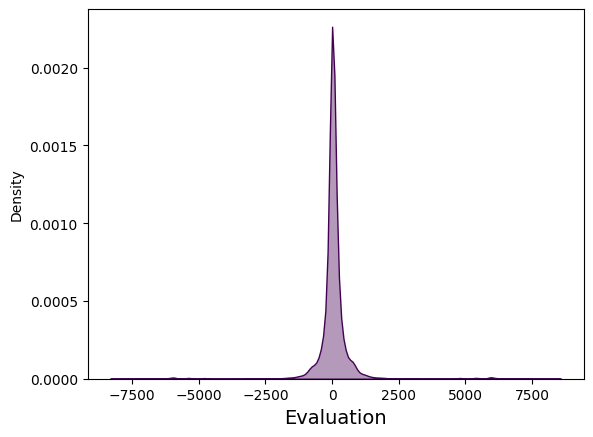

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(train[target], fill=True, alpha=0.4, label = 'KFold', color=sns.color_palette("viridis", as_cmap=True)(0))
plt.xlabel('Evaluation', fontsize=14)
plt.show()

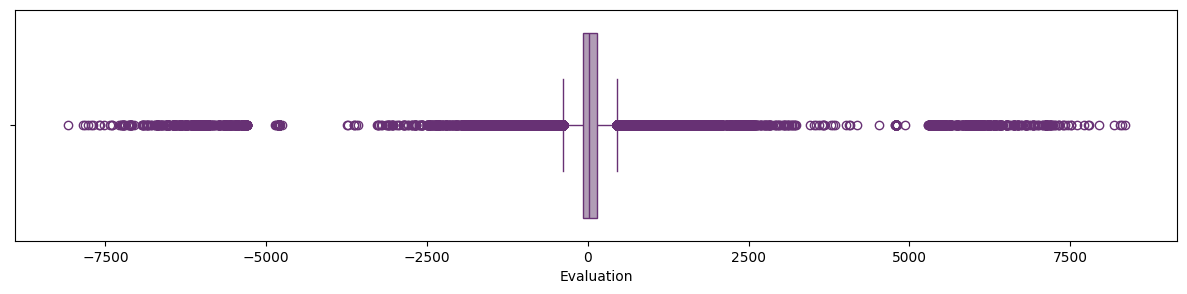

In [7]:
plt.figure(figsize=(15, 3))
sns.boxplot(x=train[target], orient='h', color='#b499ba', linecolor="#673174")
plt.show()

In [8]:
train[target].describe()

count    103664.000000
mean         44.375646
std         798.112409
min       -8087.000000
25%         -68.000000
50%          13.000000
75%         141.000000
max        8345.000000
Name: Evaluation, dtype: float64

It seems that there are many outliers relative to the target. For example, let's analyze the position with the highest evaluation.

Evaluation: 8345


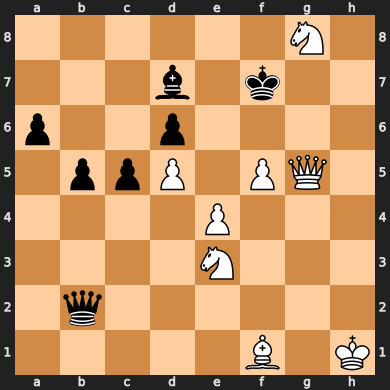

In [9]:
import chess

fen = fens.iloc[train[target].argmax()]
board = chess.Board(fen)

print("Evaluation:",train[target].max())
board

I am not a chess expert, and while it is true that black is missing two knights and there are some important white pieces near black’s king, it is not an **obviously** advantageous position for white, as indicated by the evaluation. The difference is 83.45 pawns, which is equivalent to 9 queens and a knight, for example.

Therefore, let's remove the outliers using the z-score method.

In [10]:
from scipy.stats import zscore

threshold = 2
z_score = zscore(train[target])

fens_no_outliers = fens[z_score.abs() <= threshold]
train_no_outliers = train[z_score.abs() <= threshold]

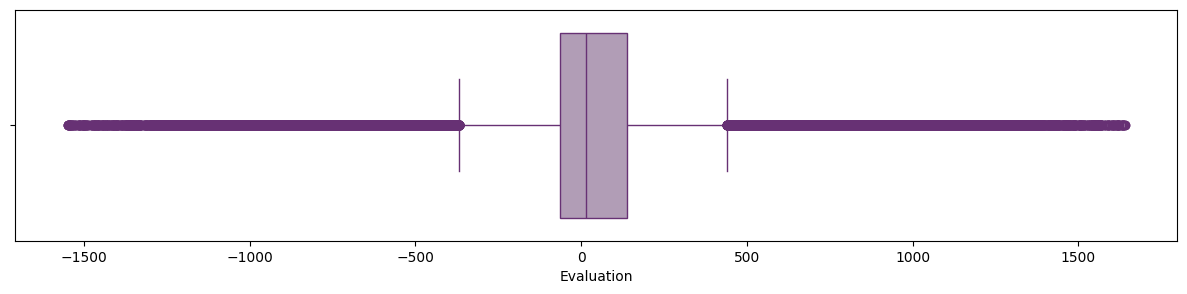

In [11]:
plt.figure(figsize=(15, 3))
sns.boxplot(x=train_no_outliers[target], orient='h', color='#b499ba', linecolor="#673174")
plt.show()

Evaluation: 1639
Turn: b


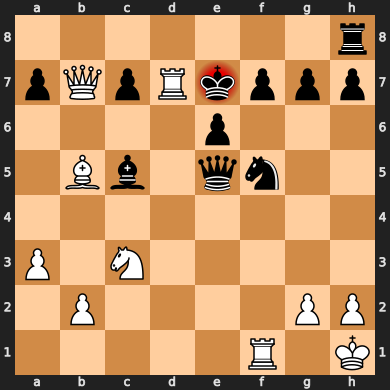

In [12]:
fen = fens_no_outliers.iloc[train_no_outliers[target].argmax()]
board = chess.Board(fen)

print("Evaluation:",train_no_outliers[target].max())
print("Turn:",fen.split()[1])

board

This is a more obvious position. Black is missing a rook and is also in check.

This evaluation is still an outlier, but it feels more reasonable. It reflects a situation that's easier to understand within the context of the game

***We’ll take these outliers into account and use methods that are more robust to their influence, getting more accurate results.***

In [13]:
fens = fens_no_outliers
train = train_no_outliers

X_train, y_train = train.drop(columns=[target]), train[target]

Now, let's analyze the extracted and selected features:

In [14]:
X_train.describe()

,White_pieces_count,Black_queen_castling,N_moves,White_legal_moves,Legal_moves_difference,Black_attacked,Attacked_difference,Black_forks,White_major_control,Major_control_difference,...,Minor_behind_pawn_difference,White_bishop_pawns,Black_bishop_pawns,Rook_on_queen_file_difference,Rook_on_open_file_difference,Long_diagonal_bishop_difference,Black_hanging_pieces,Hanging_pieces_difference,King_support_difference,Black_non_pawn_material
count,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,...,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000
mean,10.478281,0.052560,30.381878,33.059342,1.735483,2.327709,-0.139663,0.434468,20.311094,1.251288,...,-0.083322,1.423559,1.293295,-0.001135,0.026359,-0.068928,2.325804,-0.039756,-0.112484,5550.276285
std,3.496530,0.223154,14.757820,11.465381,11.315217,1.620485,1.937945,0.609995,9.575145,6.469348,...,0.724173,1.545737,1.392765,0.409319,0.649767,0.659697,1.327595,1.650265,1.211367,2663.946720
min,1.000000,0.000000,3.000000,0.000000,-63.000000,0.000000,-10.000000,0.000000,0.000000,-45.000000,...,-4.000000,0.000000,0.000000,-2.000000,-2.000000,-2.000000,0.000000,-7.000000,-6.000000,0.000000
25%,8.000000,0.000000,19.000000,26.000000,-4.000000,1.000000,-1.000000,0.000000,14.000000,-2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,-1.000000,3333.000000
50%,11.000000,0.000000,28.000000,35.000000,2.000000,2.000000,0.000000,0.000000,21.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,5871.000000
75%,13.000000,0.000000,38.000000,41.000000,8.000000,3.000000,1.000000,1.000000,27.000000,5.000000,...,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,7521.000000
max,18.000000,1.000000,177.000000,69.000000,60.000000,13.000000,10.000000,4.000000,56.000000,45.000000,...,4.000000,8.000000,8.000000,2.000000,2.000000,2.000000,9.000000,8.000000,5.000000,11665.000000


In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101294 entries, 57706 to 121958
Data columns (total 27 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   White_pieces_count               101294 non-null  int64
 1   Black_queen_castling             101294 non-null  int64
 2   N_moves                          101294 non-null  int64
 3   White_legal_moves                101294 non-null  int64
 4   Legal_moves_difference           101294 non-null  int64
 5   Black_attacked                   101294 non-null  int64
 6   Attacked_difference              101294 non-null  int64
 7   Black_forks                      101294 non-null  int64
 8   White_major_control              101294 non-null  int64
 9   Major_control_difference         101294 non-null  int64
 10  Sixth_rank_pawns_difference      101294 non-null  int64
 11  White_material_mg                101294 non-null  int64
 12  Material_mg_difference         

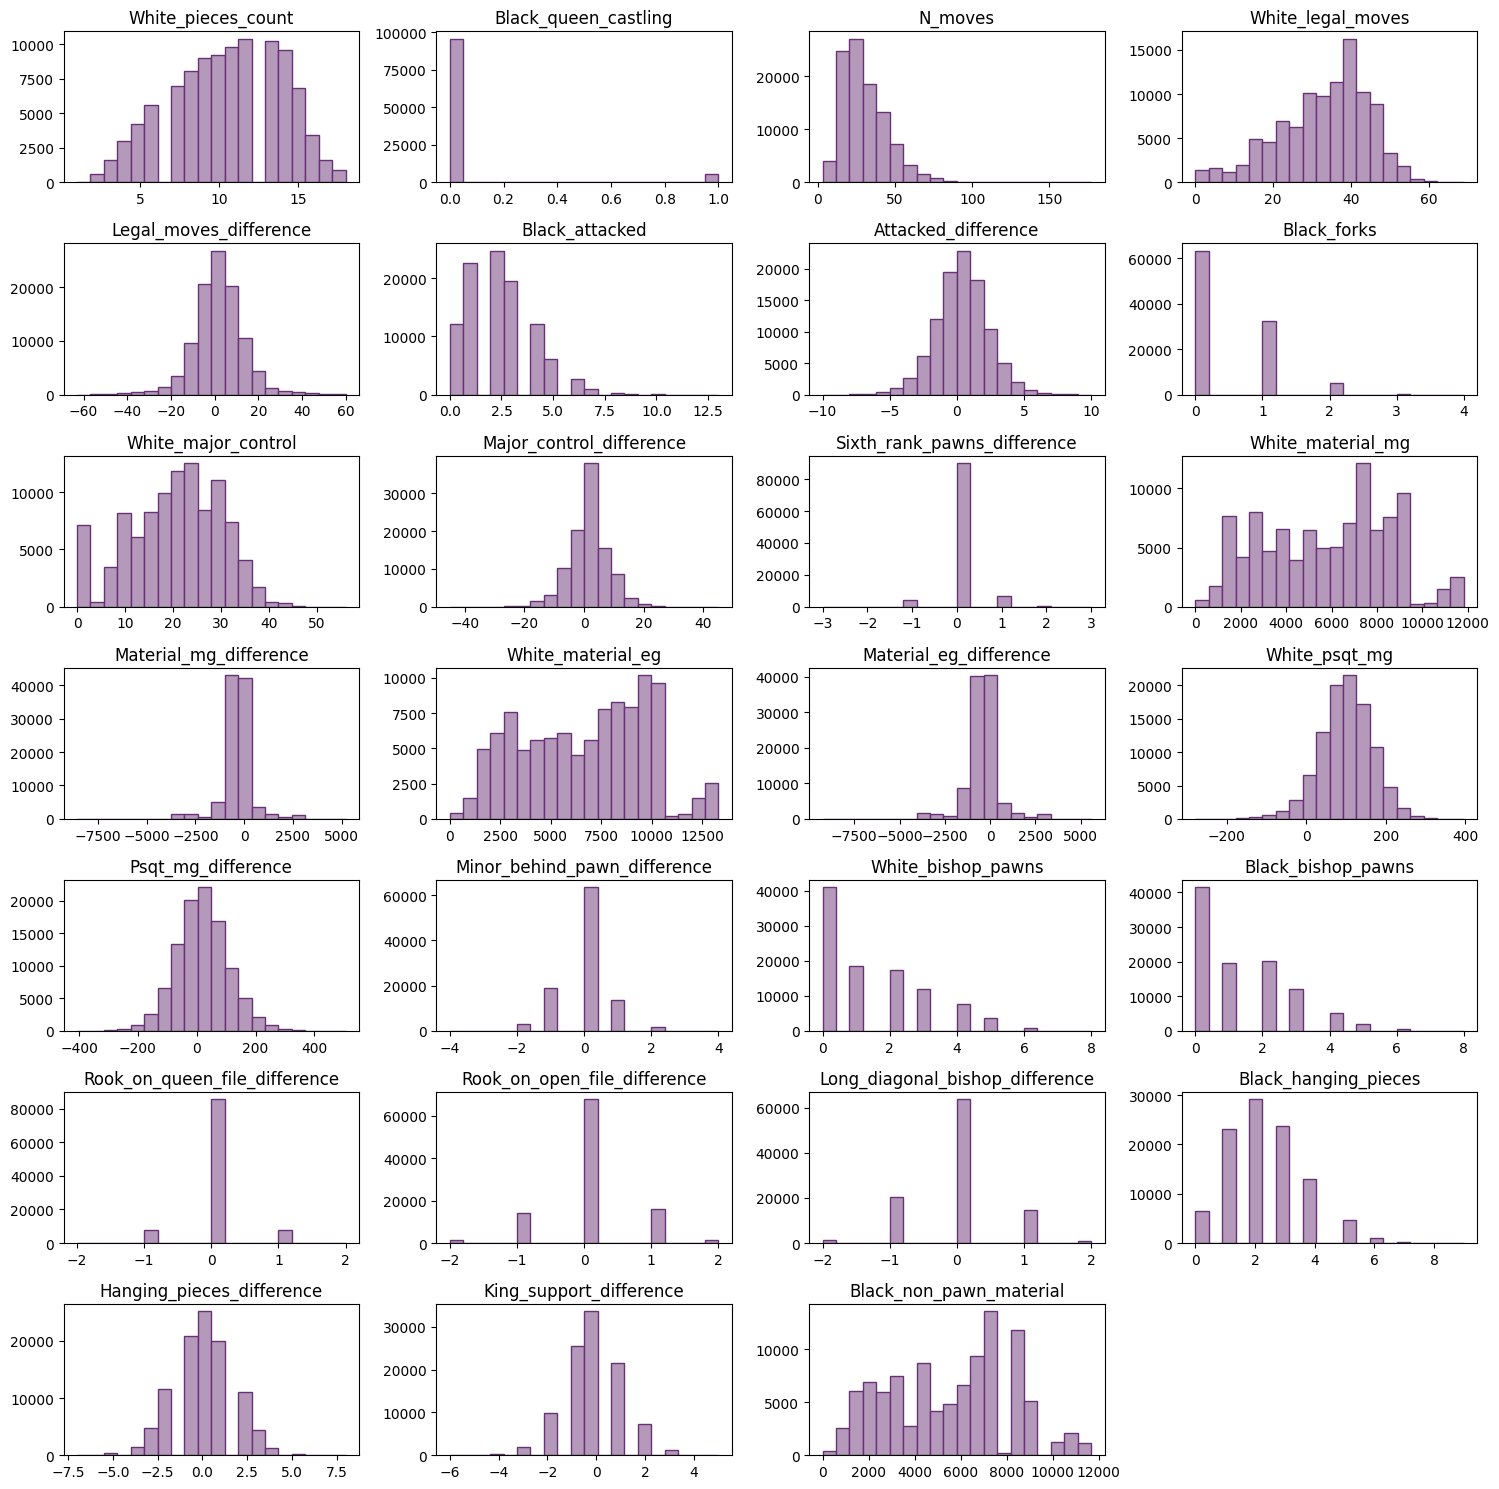

In [16]:
import matplotlib.pyplot as plt

n_features = len(X_train.columns)
n_cols = 4
n_rows = (n_features // n_cols) + (n_features % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

for i, feature in enumerate(X_train):
    axes[i].hist(X_train[feature], bins=20, edgecolor='#673174', color='#b499ba')
    axes[i].set_title(feature)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

The dataset contains both normally distributed and skewed features. **When needed**, I think these could be scaled using `RobustScaler`, as it works well for normally distributed data and is less sensitive to outliers. It also maintains the symmetry found in all features ending in *'_difference'*.  Keep in mind that this problem is related to chess, where the heuristic is symmetric: positive values are good for white, and negative values are good for black.

Although all the features are discrete (integers), some only take a few possible values, similar to categorical data. Let’s also identify and list these features.

In [17]:
threshold = 10
limited_value_features = [col for col in X_train.columns if df[col].nunique() <= threshold]

print("Features with few unique values:\n"+"="*35)
for feature in limited_value_features:
    print(feature)

X_train.describe()[limited_value_features]

Features with few unique values:
Black_queen_castling
Black_forks
Sixth_rank_pawns_difference
Minor_behind_pawn_difference
White_bishop_pawns
Black_bishop_pawns
Rook_on_queen_file_difference
Rook_on_open_file_difference
Long_diagonal_bishop_difference
Black_hanging_pieces


,Black_queen_castling,Black_forks,Sixth_rank_pawns_difference,Minor_behind_pawn_difference,White_bishop_pawns,Black_bishop_pawns,Rook_on_queen_file_difference,Rook_on_open_file_difference,Long_diagonal_bishop_difference,Black_hanging_pieces
count,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000,101294.000000
mean,0.052560,0.434468,0.025283,-0.083322,1.423559,1.293295,-0.001135,0.026359,-0.068928,2.325804
std,0.223154,0.609995,0.343794,0.724173,1.545737,1.392765,0.409319,0.649767,0.659697,1.327595
min,0.000000,0.000000,-3.000000,-4.000000,0.000000,0.000000,-2.000000,-2.000000,-2.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000
75%,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,4.000000,3.000000,4.000000,8.000000,8.000000,2.000000,2.000000,2.000000,9.000000


## 5. Model selection

This is a regression problem, so we will consider the following models:

- **Linear Regression, GLM (Generalized Linear Model) <span style="color: red">✗</span>**
    
    There are no significant correlations between the target and the extracted features, so linear models might have low performance. 

- **GPR (Gaussian Process Regression) <span style="color: red">✗</span>**

    GPR will not be considered because our dataset is too large, and GPR typically performs better with smaller datasets.

- **SVR (Support Vector Regression) <span style="color: green">✓</span>**

    Using a non-linear kernel, this model can capture complex relationships in the data.

- **KNN (K-Nearest Neighbors) <span style="color: green">✓</span>**

    KNN is a lazy model that captures non-linear relationships and performs better with more data points.

- **Random Forest <span style="color: green">✓</span>**

    Random Forest handles non-linear relationships well and, with hyperparameter tuning, can be robust to overfitting.

- **Adaboost, LightGBM, XGBoost <span style="color: green">✓</span>**

    Ensembles boost performance by combining weak learners.

- **Neural Networks <span style="color: green">✓</span>**

    Neural networks can model very complex, non-linear relationships, making them ideal for this problem. In fact, the current version of Stockfish uses neural networks.

Let's see the initial performance of two of these models (without hyperparameter tuning):

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [75]:
from sklearn.metrics import r2_score, mean_absolute_error

rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)
rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)

knn_train_pred = knn.predict(X_train)
knn_test_pred = knn.predict(X_test)

knn_train_r2 = r2_score(y_train, knn_train_pred)
knn_test_r2 = r2_score(y_test, knn_test_pred)
knn_train_mae = mean_absolute_error(y_train, knn_train_pred)
knn_test_mae = mean_absolute_error(y_test, knn_test_pred)

# Print the results in the requested format
print(f"{'Model':<25}| {'Train R²':<15}| {'Test R²':<15}| {'Train MAE':<15}| {'Test MAE':<15}")
print("-" * 90)
print(f"{'Random Forest':<25}| {rf_train_r2:<15.5f}| {rf_test_r2:<15.5f}| {rf_train_mae:<15.5f}| {rf_test_mae:<15.5f}")
print(f"{'KNN':<25}| {knn_train_r2:<15.5f}| {knn_test_r2:<15.5f}| {knn_train_mae:<15.5f}| {knn_test_mae:<15.5f}")


Model                    | Train R²       | Test R²        | Train MAE      | Test MAE       
------------------------------------------------------------------------------------------
Random Forest            | 0.90876        | 0.15371        | 62.53611       | 256.94886      
KNN                      | 0.44987        | 0.10388        | 157.84287      | 283.47539      


These results clearly show overfitting, as the model performs well on the training set but much worse on the test set. This means that the model is memorizing the training data rather than generalizing well to new, unseen data.

To avoid overfitting, we will search for the best hyperparameters for each model using cross-validation.

## 6. Model training and testing

### 6.1 Metric selection

It is necessary to choose the metric that we will use to evaluate the performance of the models. 

Remember, this is a regression problem where we are trying to predict the evaluation of a chess position in centipawns. We need to consider the large size of the dataset, that there are extreme values in the training set (relatively outliers), and the symmetry of many features (including the target), where positive values indicate an advantage for the white player and negative values indicate an advantage for the black player. Given these factors, I think the best metrics to use are:

- **MAE (Mean Absolute Error)**: This metric measures the average absolute difference between the true and predicted values, meaning the model's errors will typically be within ±MAE

  It is calculated as: $\text{MAE} = \frac{1}{n} \sum{|y_{\text{true}} - y_{\text{pred}}|}$
  
  MAE is particularly useful for symmetric targets, as it treats both positive and negative errors equally. Additionally, it is less sensitive to outliers compared to squared error metrics. Its values are expressed in the same units as the target, which in this case is **centipawns**.

Additionally, to check if the models are overfitting, we will use:

- **R²**: This metric represents the proportion of variance in the target variable explained by the model.

  It is calculated as: $R^2 = 1 - \frac{\sum{(y_{\text{true}} - y_{\text{pred}})^2}}{\sum{(y_{\text{true}} - \bar{y})^2}}$
  
  We will use it because it is an intuitive metric: A value of 1 indicates perfect prediction, 0 indicates the model is no better than predicting the mean, and negative values suggest the model performs worse than simply predicting the mean.

### 6.2 Hyperparameter Tuning

Let's find the hyperparameters that give the best results for each model. To do this, we'll use `BayesSearchCV`, which tests different combinations of hyperparameters and performs k-fold cross-validation (`cv=5`) to compare their performances. This method is much faster than GridSearchCV because it uses a probabilistic model to guide the search toward more promising areas of the parameter space, unlike `GridSearchCV`, which performs an exhaustive search.

In [18]:
from sklearn.model_selection import train_test_split

# The training set was reduced to speed up the process
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

print(f"Using {X_train_small.shape[0]} samples")

Using 10129 samples


In [19]:
import warnings
from skopt import BayesSearchCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

models = [
    ('SVR', SVR(), {
        'C': (1e-4, 1e+5, 'log-uniform'),
        'epsilon': (0.01, 1),
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto', 0.1, 1]
    }),
    
    ('KNN', KNeighborsRegressor(), {
        'n_neighbors': (1, 100),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'cosine']
    }),
    
    ('Random Forest', RandomForestRegressor(), {
        'n_estimators': (10, 500),
        'max_depth': (2, 50),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20),
        'max_features': [None, 'sqrt', 'log2'],
        'bootstrap': [True]
    }),
    
    ('AdaBoost', AdaBoostRegressor(), {
        'n_estimators': (50, 200),
        'learning_rate': (0.001, 1.0, 'uniform'),
        'loss': ['square', 'exponential'],
    }),
    
    ('LightGBM', LGBMRegressor(verbose=-1), {
        'n_estimators': (100, 1000),
        'learning_rate': (0.01, 0.5, 'uniform'),
        'num_leaves': (31, 100),
        'max_depth': (3, 20),
        'min_child_samples': (1, 50),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0),
        'reg_alpha': (0.0, 1.0),
        'reg_lambda': (0.0, 1.0)
    }),
    
    ('XGBoost', XGBRegressor(), {
        'n_estimators': (50, 500),
        'learning_rate': (0.01, 0.3, 'uniform'),
        'max_depth': (3, 20),
        'min_child_weight': (1, 20),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1),
        'gamma': (0, 0.5),
        'reg_alpha': (0, 1),
        'reg_lambda': (0, 1),
        'scale_pos_weight': (1, 10)
    })
]

warnings.filterwarnings("ignore", message="The objective has been evaluated at point")

results_mae = []

for model_name, model, param_grid in models:
    
    bayes_search = BayesSearchCV(model, param_grid, n_iter=25, cv=5, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
    bayes_search.fit(X_train_small, y_train_small)
    
    results_mae.append({
        'Model': model_name,
        'Best MAE (CV)': -bayes_search.best_score_,
        'Best Params': bayes_search.best_params_
    })

    print(f"{model_name} completed ✓")

results_mae = pd.DataFrame(results_mae)
results_mae = results_mae.sort_values(by='Best MAE (CV)', ascending=True)

SVR completed ✓
KNN completed ✓
Random Forest completed ✓
AdaBoost completed ✓
LightGBM completed ✓
XGBoost completed ✓


In [20]:
results_mae

,Model,Best MAE (CV),Best Params
5,XGBoost,171.264746,"{'colsample_bytree': 0.7473889352792509, 'gamm..."
2,Random Forest,171.568178,"{'bootstrap': True, 'max_depth': 48, 'max_feat..."
4,LightGBM,174.300880,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."
0,SVR,176.161581,"{'C': 100000.0, 'epsilon': 0.01, 'gamma': 'sca..."
1,KNN,183.430181,"{'metric': 'manhattan', 'n_neighbors': 51, 'we..."
3,AdaBoost,185.026737,"{'learning_rate': 0.059860851448838875, 'loss'..."


In [21]:
# Let's save the results
results_mae.to_csv("data/results_mae.csv", index=False)

In [19]:
csvFile = "results_mae.csv"
print(f"Reading the file '{csvFile}'...")

results_mae = pd.read_csv(f'data/{csvFile}')

print(f"File '{csvFile}' read successfully ✓")

Reading the file 'results_mae.csv'...
File 'results_mae.csv' read successfully ✓


In [38]:
from collections import OrderedDict

print(f"The best model is {results_mae.iloc[0]['Model']}, with a cross-validated MAE of {results_mae.iloc[0]['Best MAE (CV)']}")

print("The best parameters are:")
for key, value in dict(eval(results_mae.iloc[0]['Best Params'])).items():
    print(f"{key}: {value}")

The best model is XGBoost, with a cross-validated MAE of 171.2647463381767
The best parameters are:
colsample_bytree: 0.7473889352792509
gamma: 0.5
learning_rate: 0.029526545774489675
max_depth: 6
min_child_weight: 20
n_estimators: 163
reg_alpha: 0
reg_lambda: 1
scale_pos_weight: 8
subsample: 0.8632013233367994


Let's check if a Neural Network performs better than the simple models and ensembles. We will need to scale the data, as Neural Networks are sensitive to the scale of input features.

We will build a Neural Network with multiple hidden layers and use **Tanh** as the activation function because, unlike **ReLU**, it handles negative values (which is necessary given the many symmetric features). 

$Tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} \in [-1,1]$

We will search for the optimal number of layers, number of neurons, and learning rate.

In [21]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_small_scaled = scaler.fit_transform(X_train_small)

print("Data scaled successfully ✓")

Data scaled successfully ✓


In [39]:
import tensorflow as tf

def neural_network(num_layers=1, num_neurons=64, learning_rate=0.001):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(num_neurons, activation='tanh'))

    for _ in range(num_layers - 1):
        model.add(tf.keras.layers.Dense(num_neurons, activation='tanh'))

    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mae')

    return model

In [30]:
from skopt import BayesSearchCV
from scikeras.wrappers import KerasRegressor

params = {
    'model__num_layers': (1, 5),
    'model__num_neurons': (32, 256),
    'model__learning_rate': (1e-5, 1e-2, 'log-uniform')
}

model = KerasRegressor(model=neural_network, epochs=20, batch_size=32, verbose=0)

bayes_search_nn = BayesSearchCV(
    estimator=model,
    search_spaces=params,
    cv=5,
    n_iter=20,
    random_state=42,
    scoring='neg_mean_absolute_error'
    )

bayes_search_nn.fit(X_train_small_scaled, y_train_small)

print('Best MAE (CV):', -bayes_search_nn.best_score_)
print('Best Params:', bayes_search_nn.best_params_)

Best MAE (CV): 171.3693686049965
Best Params: OrderedDict([('model__learning_rate', 0.0033747526048801685), ('model__num_layers', 2), ('model__num_neurons', 227)])


We can see that the best results from the neural network hyperparameter search match those achieved with the simpler models but did not improve them.

We might be able to get better results by testing different configurations (like using a different number of neurons in each of the hidden layers), but that is not the main objective here. The goal is to see how closely we can approach the target values using simpler models.

## 7. Model evaluation

Now that we have identified the best models with optimal hyperparameters, the next step is to check for overfitting and evaluate their accuracy in predicting the actual target values. 

For this, we will use the full training set and the testing set, which the models have not seen before.

First, let's define some useful functions to plot the results:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

def plot_model_mae_r2(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    margin_mae = max(mae_train, mae_test) * 0.05
    margin_r2 = 0.05

    fig, ax1 = plt.subplots(figsize=(6, 5))
    ax1.bar(['Train', 'Test'], [mae_train, mae_test], width=0.8, color='#4f105f', label='MAE')
    ax1.set_ylabel('MAE', color='#4f105f',fontsize=14)
    ax1.set_title('Model Performance: MAE & R²')
    ax1.set_ylim(0, max(mae_train, mae_test) * 1.2)

    for i, v in enumerate([mae_train, mae_test]):
        ax1.text(i, v + margin_mae, f'{v:.3f}', ha='center', va='bottom', fontsize=12, color='#4f105f')

    ax2 = ax1.twinx()
    ax2.plot(['Train', 'Test'], [r2_train, r2_test], color='orange', marker='o', label='R²')
    ax2.set_ylabel('R²', color='orange',fontsize=14)
    ax2.set_ylim(0, 1.1)
    ax1.set_xlim(-0.5, 1.5)

    for i, v in enumerate([r2_train, r2_test]):
        ax2.text(i, v + margin_r2, f'{v:.3f}', ha='center', va='bottom', fontsize=12, color='orange')

    plt.tight_layout()
    plt.show()

def plot_learning_curve(model, score, X_train, y_train, X_test, y_test, steps=10, score_name='Prediction Score'):
    train_list, test_list = [], []
    train_sizes = []

    for i in range(1, steps + 1):
        index = int(i * len(X_train) / steps)
        train_sizes.append(index)
        model.fit(X_train[:index], y_train[:index])
        train_list.append(score(y_train[:index], model.predict(X_train[:index])))
        test_list.append(score(y_test, model.predict(X_test)))

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_list, label='Train Score', color='purple')
    plt.plot(train_sizes, test_list, label='Test Score', color='orange')
    plt.title('Learning Curves (Train vs. Test)')
    plt.xlabel('Number of Training Samples')
    plt.ylabel(score_name)
    plt.ylim(0)
    plt.legend()
    plt.show()

def plot_predicted_vs_actual(model, X_test, y_test):
    y_test_pred = model.predict(X_test)
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test, y_test_pred, color='purple', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='orange', linestyle='--')
    plt.title('Predicted vs Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

Now, let's evaluate the models:

### 7.1 XGBRegressor - Ensemble

In [99]:
from xgboost import XGBRegressor

params = {
    'colsample_bytree': 0.7473889352792509,
    'gamma': 0.5,
    'learning_rate': 0.029526545774489675,
    'max_depth': 6,
    'min_child_weight': 20,
    'n_estimators': 163,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 8,
    'subsample': 0.8632013233367994,
}

xgb = XGBRegressor(**params, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7473889352792509, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.029526545774489675, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=20, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=163, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

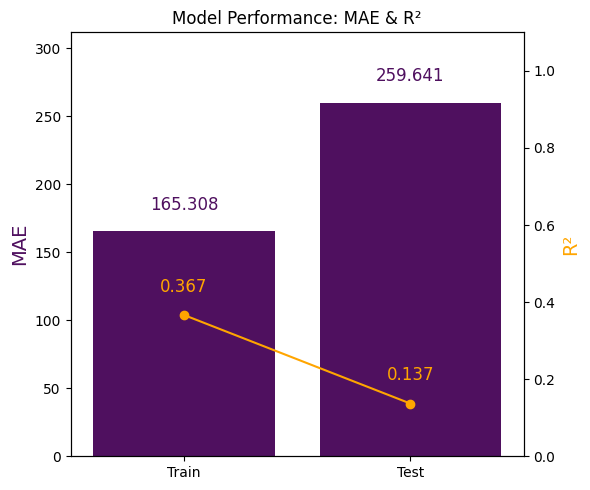

In [94]:
plot_model_mae_r2(xgb, X_train, y_train, X_test, y_test)

The difference between the R² values in the training and test sets suggests that, although we performed cross-validation to find the best model, there might be **overfitting**. However, this difference is now smaller.

### 7.2 KerasRegressor - Neural Network (Tensorflow)

In [50]:
from scikeras.wrappers import KerasRegressor

params_nn = {
    'learning_rate': 0.0033747526048801685,
    'num_layers': 2,
    'num_neurons': 227
}

nn = KerasRegressor(model=neural_network(**params_nn), epochs=20, batch_size=32, verbose=0, random_state=42)
nn.fit(X_train, y_train)

KerasRegressor(
	model=<Sequential name=sequential_459, built=True>
	build_fn=None
	warm_start=False
	random_state=42
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
)

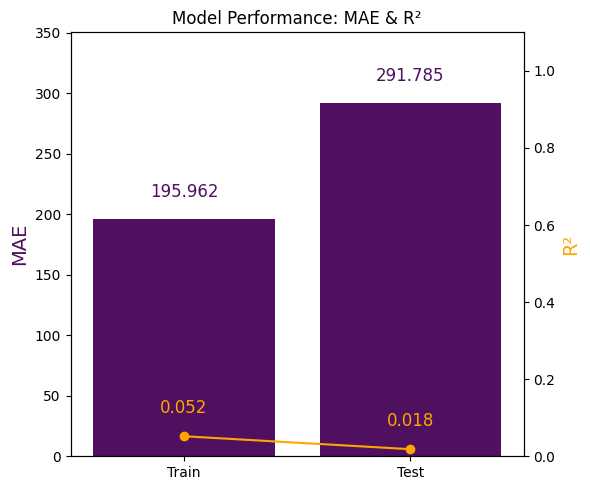

In [97]:
plot_model_mae_r2(nn, X_train, y_train, X_test, y_test)

This R² results show **underfitting** because the model performs poorly on both the training and test sets, indicating it can't capture the complex patterns in the data.

### 7.3 Analysis of Results

The model that achieved the best results overall is the XGBRegressor, though it appears to be overfitting.

Let's take a look at its learning curves:

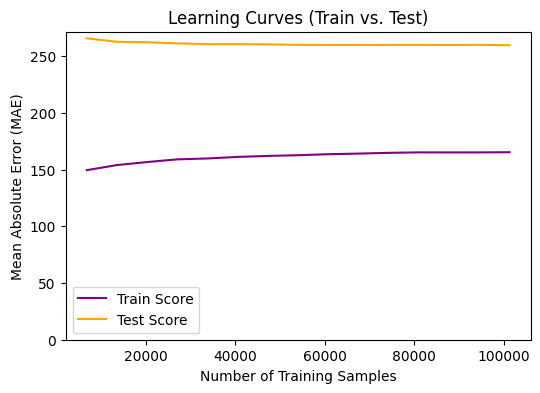

In [79]:
from sklearn.metrics import mean_absolute_error

plot_learning_curve(xgb, mean_absolute_error, X_train, y_train, X_test, y_test, 15, 'Mean Absolute Error (MAE)')

They are significantly separated, which indicates that the model fits the training set better than the unseen data.

There are many reasons that could be causing this:

- **Few training data <span style="color: red">✗</span>**:

    We trained the model with 101294 samples, so this is not the cause of the overfitting.

- **Lots of features <span style="color: red">✗</span>**:

    While 26 features might seem like a lot, they were chosen using regularization, which helps reduce the chance of overfitting. Fewer features were not considered because none of the selected features have high correlation with the target.

- **Excessive complexity <span style="color: red">✗</span>**:

    The hyperparameters found in the search could add some complexity in the XGBRegressor, but they aren't extreme. We also used cross-validation to select them, which helps in detecting and preventing overfitting.

There is only one more reason that could explain the results difference between the cross-validation and the test set (MAE: $171.26$ centipawns and $259.64$ centipawns respectively): **Data mismatch between training and test set**

Previously, we identified some extreme outliers in the dataset, which could be affecting the test set performance. While the test set is meant to represent real unseen data, samples with extreme target values, like the one seen in [4. EDA](#4-eda-exploratory-data-analysis), can negatively impact metrics like R², which are sensitive to outliers.

Let's remove the outliers from the test set using the same z-score threshold as the training set, but based on the test set's distribution *(outliers have been computed separately for the training and test sets to avoid data leakage)*, and then analyze the results:

In [80]:
from scipy.stats import zscore

threshold = 2
z_score = zscore(test[target])

test_no_outliers = test[z_score.abs() <= threshold]

X_test_no_outliers, y_test_no_outliers = test_no_outliers.drop(columns=[target]), test_no_outliers[target]

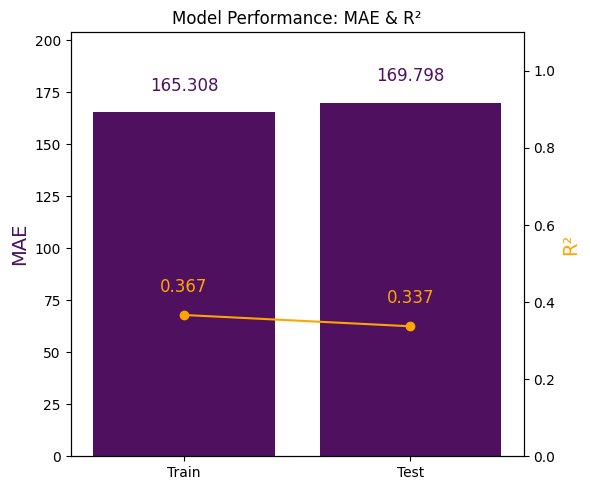

In [98]:
plot_model_mae_r2(xgb, X_train, y_train, X_test_no_outliers, y_test_no_outliers)

These results are now better.

The final result is $\boxed{\text{MAE: }169.798}$, which might seem high, but it's important to remember that the units are **centipawns**, which means that the mean absolute error is actually less than $2.00$ pawns. In other words, the model can predict the target with an error margin of $\pm 1.69$ pawns.

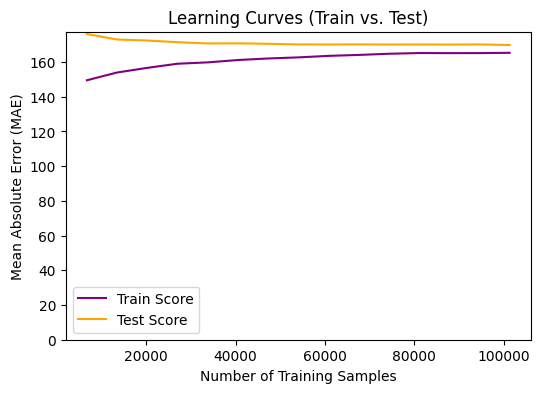

In [81]:
from sklearn.metrics import mean_absolute_error

plot_learning_curve(xgb, mean_absolute_error, X_train, y_train, X_test_no_outliers, y_test_no_outliers, 15, 'Mean Absolute Error (MAE)')

Now, these curves are closer.

Prediction with extreme values in the test set:


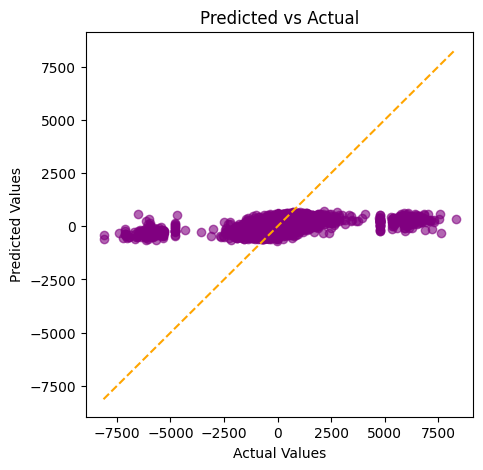

Prediction after removing extreme values from the test set:


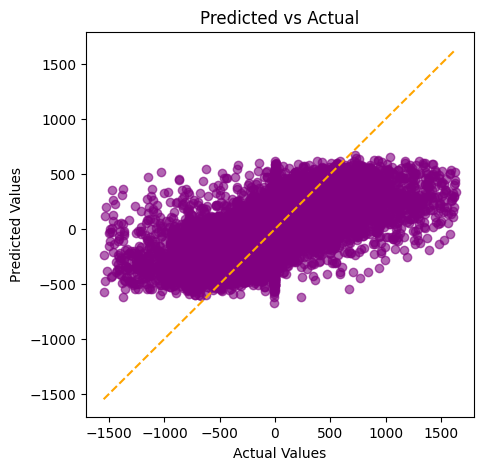

In [100]:
print("Prediction with extreme values in the test set:")
plot_predicted_vs_actual(xgb, X_test, y_test)
print("Prediction after removing extreme values from the test set:")
plot_predicted_vs_actual(xgb, X_test_no_outliers, y_test_no_outliers)

## 8. Conclusion

In this notebook, we aimed to predict the evaluation score of a chess position using regression models.

We extracted up to 85 features from the FEN string of the position and used Lasso for feature selection, removing many of them.

After processing the data, we tested various machine learning models with different hyperparameters to find the best of them.

The **XGBRegressor** performed the best. While the neural network showed potential, it did not outperform the simpler models, suggesting that it might require more complex adjustments (which was not the goal of this project).

We encountered challenges with outliers and overfitting, but handled them through techniques like cross-validation, regularization, and outlier removal.

The final result is a model that predicts the evaluations with an error margin of $\pm 1.69798$ pawns on samples that did not have *extreme target values*.

The results of this project are not very impressive, which is understandable, as it is difficult for regression models to match the depth and accuracy of algorithms like *Stockfish*.

## References

1. [Chess Piece Relative Value - Wikipedia](https://en.wikipedia.org/wiki/Chess_piece_relative_value)
2. [Doubled pawns - Wikipedia](https://en.wikipedia.org/wiki/Doubled_pawn)
3. [Fork (chess) - Wikipedia](https://en.wikipedia.org/wiki/Fork_(chess))
4. [Open file - Wikipedia](https://en.wikipedia.org/wiki/Open_file)

### Additional Resources

- [Chess Evaluations Dataset - Kaggle](https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations/data)
- [Programming a Computer for Playing Chess - Claude Shannon](https://archive.computerhistory.org/projects/chess/related_materials/text/2-0%20and%202-1.Programming_a_computer_for_playing_chess.shannon/2-0%20and%202-1.Programming_a_computer_for_playing_chess.shannon.062303002.pdf)
- [Stockfish Evaluation Guide](https://hxim.github.io/Stockfish-Evaluation-Guide/)
- [Official Stockfish Documentation](https://official-stockfish.github.io/docs/)
- [Evaluation Function - Wikipedia](https://en.wikipedia.org/wiki/Evaluation_function)
- [Lichess Analysis Tool](https://lichess.org/analysis)